In [2]:
"""
Created on 15-01-2024
Pricing of European Call and Put options using the FFT
@author: Magnus Højmark Kristensen
"""

import numpy as np # Has to be 1.20 version as np.long was deprecated (used in jnit)
from numpy import sqrt, exp, pi, cos, sin, log, abs
from numba import njit # For significantly faster numpy computations
import matplotlib.pyplot as plt
#import pandas as pd

## Functions

In [3]:
@njit
def Fourier_Heston_Put(S0, K, T, r, 
                    # Heston Model Paramters
                    kappa,      # Speed of the mean reversion 
                    theta,      # Long term mean
                    rho,        # correlation between 2 random variables
                    zeta,       # Volatility of volatility
                    v0,         # Initial volatility 
                    opt_type,   # Option type
                    N = 2048):

    # Characteristic function of the Heston model
    def heston_char(u, kappa, theta, rho, zeta, v0): 
        t0 = 0.0 ;  q = 0.0
        m = log(S0) + (r - q)*(T-t0)
        D = sqrt((rho*zeta*1j*u - kappa)**2 + zeta**2*(1j*u + u**2))
        C = (kappa - rho*zeta*1j*u - D) / (kappa - rho*zeta*1j*u + D)
        beta = ((kappa - rho*zeta*1j*u - D)*(1-exp(-D*(T-t0)))) / (zeta**2*(1-C*exp(-D*(T-t0))))
        alpha = ((kappa*theta)/(zeta**2))*((kappa - rho*zeta*1j*u - D)*(T-t0) - 2*log((1-C*exp(-D*(T-t0))/(1-C))))
        return exp(1j*u*m + alpha + beta*v0)

    # Parameters for the Function to make sure the approximations are correct.
    c1 = log(S0) + r*T + (1 - exp(-kappa*T))*(theta-v0)/(2*kappa) - (1/2)*theta*T
    c2 = (
        (1/(8*kappa**3)) * (zeta*T*kappa*exp(-kappa*T)*(v0-theta)*(8*kappa*rho-4*zeta)
        + kappa*rho*zeta*(1-exp(-kappa*T))*(16*theta-8*v0)
        + 2*theta*kappa*T*(-4*kappa*rho*zeta + zeta**2 + 4*kappa**2)
        + zeta**2*((theta - 2*v0)*exp(-2*kappa*T) + theta*(6*exp(-kappa*T)-7) + 2*v0)
        + 8*kappa**2*(v0-theta)*(1-exp(-kappa*T)))
    )
    a = c1 - 24*sqrt(abs(c2))
    b = c1 + 24*sqrt(abs(c2))

    h       = lambda n : (n*pi) / (b-a) 
    g       = lambda n : (exp(a) - (K/h(n))*sin(h(n)*(a - log(K))) - K*cos(h(n)*(a - log(K)))) / (1 + h(n)**2)
    g0      = K*(log(K) - a - 1) + exp(a)
    

    F = g0 
    for n in range(1, N+1):
        h_n = h(n)
        F += 2*heston_char(h_n, kappa, theta, rho, zeta, v0) * exp(-1j*a*h_n) * g(n)

    F = exp((-r*T))/(b-a) * np.real(F)
    F = F if opt_type == 'p' else F + S0 - K*exp(-r*T)
    return F if F > 0 else 0

## Parameters

In [4]:
args = {
'S0'      : 100.0 ,
# 'K'       : 100.0 ,
'r'       : 0.05 ,
# 'T'       : 5.0 ,

'kappa' : 1.5768,   # rate of mean reversion of variance process
'theta' : 0.0398,   # long-term mean variance
'zeta' : 0.3,       # volatility of volatility
'rho' : -0.5711,    # correlation between variance and stock process
'v0' : 0.1,         # initial variance

'N' : 96,
'opt_type' : 'p'
}

Ns = [8, 16,32, 64, 256]
df = {'N' : Ns, 'avg_residuals' : [], 'Ex. Time' : []}

Ks = np.linspace(0, 300, 50)[1:] # Strike prices

# Time to maturity
Ts = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
# Ts = np.linspace(0,1, 50)
# Ts = np.logspace(np.log10(1/365),np.log10(1), 50)
Ts

array([ 0.08333333,  0.16666667,  0.25      ,  0.33333333,  0.5       ,
        1.        ,  2.        ,  3.        ,  5.        ,  7.        ,
       10.        , 20.        , 30.        ])

## Results

In [5]:
# Compute computational efficiency using the IPython shell.
%timeit Fourier_Heston_Put(100.0, 100.0, 1.0, 0.05, 1.5768, 0.0398, -0.5711, 0.3, 0.1, 'p', N = 1012)

# Compute prices and save them
# Initialize storage
results = {
        'K'                 : [], 
        'T'                 : [],
        'Price Heston'      : [],
        }
for K in Ks:
    for T in Ts:
        args['K'] = K
        args['T'] = T
        results['K'].append( K )
        results['T'].append( T )
        results['Price Heston'].append(Fourier_Heston_Put(**args))

818 µs ± 243 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
results['Price Heston'][0:len(Ts)]

[0.0024084988494944112,
 1.205268597261022e-05,
 4.2089223001490297e-05,
 4.602530727953351e-05,
 4.6774893809421844e-05,
 4.778180284536272e-05,
 5.983222014218115e-05,
 8.967478191378542e-05,
 0.00018861300066322305,
 0.0003201309422279262,
 0.0005581967983714347,
 0.001291554649223789,
 0.0015044373258072538]

In [27]:
len(Ts)

13

[0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]
[128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856, 128.57142857142856]


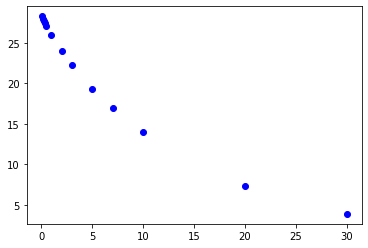

In [33]:
k = 20
print(results['T'][k*len(Ts):(1+k)*len(Ts)]) # Time to maturity
print(results['K'][k*len(Ts):(1+k)*len(Ts)]) # Strike price
plt.plot(results['T'][k*len(Ts):(1+k)*len(Ts)], results['Price Heston'][k*len(Ts):(1+k)*len(Ts)], 'bo')

In [7]:
results['Price Heston']



[0.0024084988494944112,
 1.205268597261022e-05,
 4.2089223001490297e-05,
 4.602530727953351e-05,
 4.6774893809421844e-05,
 4.778180284536272e-05,
 5.983222014218115e-05,
 8.967478191378542e-05,
 0.00018861300066322305,
 0.0003201309422279262,
 0.0005581967983714347,
 0.001291554649223789,
 0.0015044373258072538,
 1.9426752746432217e-05,
 0.0006653019844292316,
 0.0007181078131803634,
 0.0007253460633735607,
 0.0007336564658478995,
 0.0007824129308532962,
 0.0010967799133365093,
 0.0016962915250276227,
 0.003205020664140108,
 0.004857799797672606,
 0.007291036230623958,
 0.011833516080195021,
 0.011112894892522172,
 0.0022815027197042605,
 0.0035279087572491212,
 0.0036072220775415103,
 0.003640026270254891,
 0.0037096080578707456,
 0.004095556004390888,
 0.006283321995056267,
 0.00956275103516401,
 0.016456751298625245,
 0.023028208029775846,
 0.03130718751423836,
 0.040945088041489636,
 0.034033614971177815,
 0.009649793224562322,
 0.011187867671966686,
 0.011359955649483644,
 0.01149